In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import matplotlib.dates as mdates

In [ ]:
price_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/prices.csv')

In [ ]:
# Assuming 'df' is your loaded CSV
df = price_df.sort_values('date')

# Calculate Log Returns
df['log_ret'] = np.log(df['price']).diff()
returns_scaled = df['log_ret'].dropna().values


In [61]:
df.head()

,date,price,log_return,log_ret
0,1987-05-20,18.63,NaN,NaN
1,1987-05-21,18.45,-0.009709,-0.009709
2,1987-05-22,18.55,0.005405,0.005405
3,1987-05-25,18.60,0.002692,0.002692
4,1987-05-26,18.63,0.001612,0.001612


In [46]:
key_events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/events.csv')

In [47]:
key_events['even t_date'] = pd.to_datetime(key_events['event_date'])

In [ ]:

n = len(returns_scaled)
idx = np.arange(n)

with pm.Model() as model:
    # 1. Switch Point (Discrete Prior)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n - 1)

    # 2. Before and After Parameters
    mu1 = pm.Normal("mu1", mu=0, sigma=1)
    mu2 = pm.Normal("mu2", mu=0, sigma=1)
    sigma1 = pm.HalfNormal("sigma1", sigma=1)
    sigma2 = pm.HalfNormal("sigma2", sigma=1)

    # 3. Switch Function
    # If index < tau, use mu1/sigma1; else use mu2/sigma2
    mu = pm.math.switch(idx < tau, mu1, mu2)
    sigma = pm.math.switch(idx < tau, sigma1, sigma2)

    # 4. Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=returns_scaled)

    # 5. Track the change (Quantify Impact)
    delta_mu = pm.Deterministic("delta_mu", mu2 - mu1)

    # 6. Run Sampler
    # Note: Categorical/Discrete variables use Metropolis; Continuous use NUTS.
    trace = pm.sample(1000, tune=1000, chains=4, return_inferencedata=True)

Output()

In [69]:
print(trace.posterior.data_vars.keys())

KeysView(Data variables:
    delta_mu  (chain, draw) float64 32kB -0.004357 0.009089 ... -0.0488 -0.03683
    mu1       (chain, draw) float64 32kB -0.001363 -0.009086 ... 0.01412
    mu2       (chain, draw) float64 32kB -0.005721 3.25e-06 ... -0.02271
    sigma1    (chain, draw) float64 32kB 0.9037 0.899 0.9112 ... 0.9051 0.8903
    sigma2    (chain, draw) float64 32kB 1.116 1.135 1.137 ... 1.138 1.147 1.141
    tau       (chain, draw) int64 32kB 5362 5383 5383 5420 ... 5361 5361 5361)


In [71]:
# Matching the exact keys from your KeysView:
az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma1", "sigma2", "delta_mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5390.018,20.735,5349.000,5423.000,0.924,0.563,519.0,920.0,1.0
mu1,0.006,0.013,-0.017,0.030,0.000,0.000,6366.0,3382.0,1.0
mu2,-0.009,0.019,-0.043,0.028,0.000,0.000,6303.0,3347.0,1.0
sigma1,0.902,0.009,0.887,0.919,0.000,0.000,6179.0,3422.0,1.0
sigma2,1.130,0.014,1.105,1.155,0.000,0.000,6295.0,2475.0,1.0
delta_mu,-0.016,0.023,-0.057,0.028,0.000,0.000,5955.0,3100.0,1.0


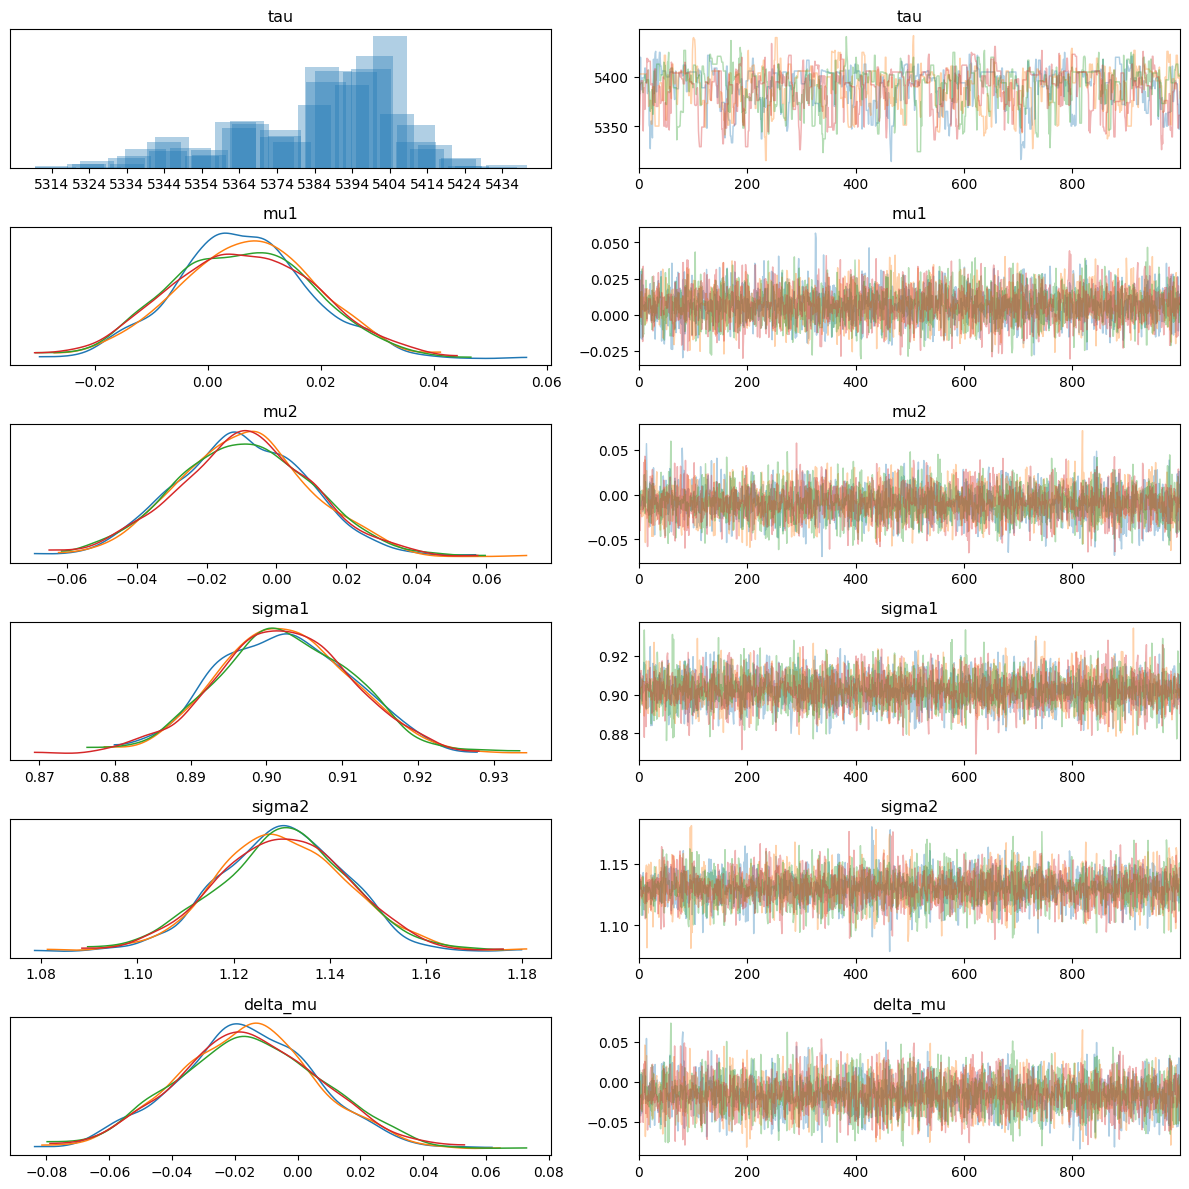

In [ ]:
az.plot_trace(trace,
              var_names=["tau", "mu1", "mu2", "sigma1", "sigma2", "delta_mu"],
              combined=False,
              compact=False)

plt.tight_layout()
plt.show()

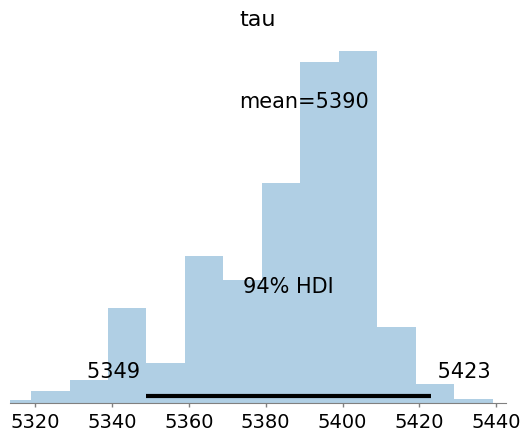

In [73]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()


In [74]:
tau_samples = trace.posterior['tau'].values.flatten()
tau_date = df.loc[int(np.median(tau_samples)), 'date']

tau_date


'2008-08-05'

In [75]:
# Extract the median value of tau from all chains
tau_samples = trace.posterior["tau"].values.flatten()
median_tau_idx = int(np.median(tau_samples))

# Map index to the actual date in your dataframe
# Note: if you used returns_scaled, index 0 is actually df['Date'].iloc[1]
change_date_str = df['date'].iloc[median_tau_idx + 1]
change_date = pd.to_datetime(change_date_str)

print(f"Detected Change Point Date: {change_date.strftime('%Y-%m-%d')}")

Detected Change Point Date: 2008-08-06


In [76]:
# Get summary statistics
summary = az.summary(trace, var_names=["mu1", "mu2", "sigma1", "sigma2", "delta_mu"])

# Extract specific values
m1, m2 = summary.loc["mu1", "mean"], summary.loc["mu2", "mean"]
s1, s2 = summary.loc["sigma1", "mean"], summary.loc["sigma2", "mean"]
d_mu = summary.loc["delta_mu", "mean"]

print(f"--- Quantitative Impact Analysis ---")
print(f"Pre-change Mean:  {m1:.5f}")
print(f"Post-change Mean: {m2:.5f}")
print(f"Absolute Shift:   {d_mu:.5f}")
print(f"Volatility Change (Sigma): {s1:.4f} -> {s2:.4f}")

--- Quantitative Impact Analysis ---
Pre-change Mean:  0.00600
Post-change Mean: -0.00900
Absolute Shift:   -0.01600
Volatility Change (Sigma): 0.9020 -> 1.1300


In [78]:
mu1 = trace.posterior['mu1'].values.flatten()
mu2 = trace.posterior['mu2'].values.flatten()

impact_pct = (mu2.mean() - mu1.mean()) / abs(mu1.mean()) * 100
impact_pct


np.float64(-247.86468226652212)

In [79]:
# Calculate the difference in days for every event
# Ensure change_date is a datetime object for subtraction
change_date_dt = pd.to_datetime(change_date)
# Ensure key_events['event_date'] is also datetime type
key_events['event_date'] = pd.to_datetime(key_events['event_date'])
key_events['days_diff'] = (key_events['event_date'] - change_date_dt).dt.days.abs()

# Find the closest event
closest_event = key_events.loc[key_events['days_diff'].idxmin()]

print(f"--- Event Association Analysis ---")
print(f"Model Change Point: {change_date_dt.strftime('%Y-%m-%d')}")
print(f"Closest Global Event: {closest_event['event_name']} on {closest_event['event_date'].strftime('%Y-%m-%d')}")
print(f"Proximity: {closest_event['days_diff']} days")

--- Event Association Analysis ---
Model Change Point: 2008-08-06
Closest Global Event: Oil All-Time High on 2008-07-11
Proximity: 26 days


In [ ]:
# 1. Extract model results
median_tau_idx = int(np.median(trace.posterior["tau"].values.flatten()))
change_date = pd.to_datetime(df['date'].iloc[median_tau_idx])


# 3. Compile the data
results_data = {
    "detected_date": [change_date.strftime('%Y-%m-%d')],
    "median_tau_index": [median_tau_idx],
    "associated_event": [closest_event['event_name']],
    "event_category": [closest_event['category']],
    "proximity_days": [closest_event['days_diff']],
    "mu_pre_change": [summary.loc["mu1", "mean"]],
    "mu_post_change": [summary.loc["mu2", "mean"]],
    "sigma_pre_change": [summary.loc["sigma1", "mean"]],
    "sigma_post_change": [summary.loc["sigma2", "mean"]]
}

changepoints_df = pd.DataFrame(results_data)

In [82]:
# Save the file
changepoints_df.to_csv('/content/drive/MyDrive/Colab Notebooks/changepoints.csv"', index=False)

print("File saved successfully as 'changepoints.csv'")

File saved successfully as 'changepoints.csv'


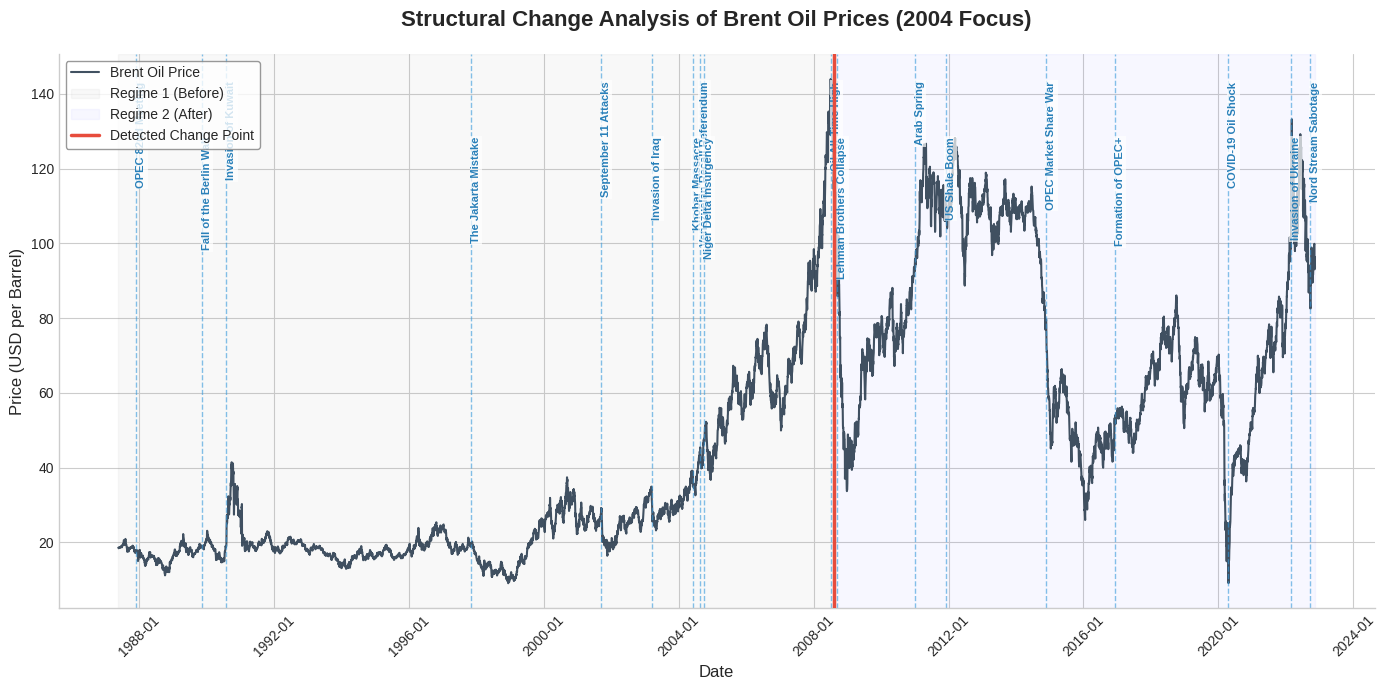

In [ ]:
# --------------------------------------------------
# Figure setup and visual style
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")
fig, ax = plt.subplots(figsize=(14, 7), dpi=100)

# --------------------------------------------------
# 1. Price time series
# --------------------------------------------------
# Plot Brent oil prices with a clean, readable line
ax.plot(
    df["date"],
    df["price"],
    label="Brent Oil Price",
    color="#2c3e50",
    linewidth=1.5,
    alpha=0.9
)

# --------------------------------------------------
# 2. Regime shading (before vs after change point)
# --------------------------------------------------
ax.axvspan(
    df["date"].min(),
    change_date,
    color="gray",
    alpha=0.05,
    label="Regime 1 (Before)"
)

ax.axvspan(
    change_date,
    df["date"].max(),
    color="blue",
    alpha=0.03,
    label="Regime 2 (After)"
)

# --------------------------------------------------
# 3. Detected structural change point
# --------------------------------------------------
ax.axvline(
    change_date,
    color="#e74c3c",
    linewidth=2.5,
    label="Detected Change Point",
    zorder=5
)

# --------------------------------------------------
# 4. External events annotation
# --------------------------------------------------
# Place event labels near the top to avoid clutter
y_min, y_max = ax.get_ylim()

for i, row in events_df.iterrows():
    # Vertical marker for each event
    ax.axvline(
        row["event_date"],
        color="#3498db",
        linestyle="--",
        linewidth=1,
        alpha=0.6
    )

    # Alternate label position slightly to reduce overlap
    offset = 0.05 if i % 2 == 0 else 0.15

    ax.text(
        row["event_date"],
        y_max - (y_max - y_min) * offset,
        row["event_name"],
        rotation=90,
        fontsize=8,
        fontweight="bold",
        color="#2980b9",
        verticalalignment="top",
        bbox=dict(
            facecolor="white",
            alpha=0.7,
            edgecolor="none",
            pad=1
        )
    )

# --------------------------------------------------
# 5. Axis formatting
# --------------------------------------------------
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

# --------------------------------------------------
# 6. Titles, labels, and legend
# --------------------------------------------------
ax.set_title(
    "Structural Change Analysis of Brent Oil Prices (2004 Focus)",
    fontsize=16,
    fontweight="bold",
    pad=20
)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD per Barrel)", fontsize=12)

ax.legend(
    loc="upper left",
    frameon=True,
    facecolor="white",
    edgecolor="gray"
)

# Remove unnecessary borders for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()
